In [1]:
#### Import dependencies
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

from pyspark.ml import Pipeline

from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

/opt/conda/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .appName("SMS spam filtering with Multilayer Perceptron Classifier") \
    .enableHiveSupport() \
    .getOrCreate()

In [4]:
raw_dataset = spark.read.table("public_datasets.sms_spam_collection")

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used


In [5]:
# Show the count of each class
class_counts = raw_dataset.groupBy('label').count()

# Calculate and display the class distribution
total_count = raw_dataset.count()
class_counts.withColumn('Percentage', (class_counts['count'] / total_count) * 100).show()


+-----+-----+-----------------+
|label|count|       Percentage|
+-----+-----+-----------------+
|  ham| 4827|86.59849300322928|
| spam|  747|13.40150699677072|
+-----+-----+-----------------+



In [6]:
# StringIndexer to convert string labels to numerical labels
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")

In [7]:
# Tokenize the SMS text
tokenizer = Tokenizer(inputCol="text", outputCol="words")

In [8]:
# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [9]:
# Hashing TF to convert words to numerical features
hashingTF = HashingTF(inputCol="filtered_words", outputCol="numerical_features", numFeatures=5000)

In [10]:
# TF-IDF
idf = IDF(inputCol="numerical_features", outputCol="features")

In [11]:
prep_pipeline = Pipeline(stages=[label_indexer, tokenizer, remover, hashingTF, idf])

processed_dataset = prep_pipeline.fit(raw_dataset).transform(raw_dataset)

In [12]:
dataset = processed_dataset.select("label_index", "features")

In [13]:
dataset.printSchema()

root
 |-- label_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [14]:
dataset.show(5)

+-----------+--------------------+
|label_index|            features|
+-----------+--------------------+
|        0.0|(5000,[98,740,750...|
|        0.0|(5000,[1727,2630,...|
|        1.0|(5000,[581,587,10...|
|        0.0|(5000,[594,862,31...|
|        0.0|(5000,[1197,1515,...|
+-----------+--------------------+
only showing top 5 rows



In [15]:
# Split the dataset into training and testing sets
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed=42)

In [16]:
# Create an MLP classifier
layers = [5000, 100, 50, 2]  # Input: 5000 features, two hidden layers, output: binary (spam or ham)
mlp_classifier = MultilayerPerceptronClassifier(
    labelCol="label_index",
    featuresCol="features",
    layers=layers,
    blockSize=128,
    seed=42)

pipeline = Pipeline(stages=[mlp_classifier])

# Train the MLP classifier
mlp_model = pipeline.fit(trainingData)

23/10/13 16:05:09 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/10/13 16:05:09 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [17]:
# Make predictions on the test set
predictions = mlp_model.transform(testData)

# Evaluate the classifier
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_index",
    predictionCol="prediction",
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

23/10/13 16:05:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


Accuracy: 0.9794584500466853


In [18]:
predictions.show(5)

23/10/13 16:05:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


+-----------+--------------------+--------------------+--------------------+----------+
|label_index|            features|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+----------+
|        0.0|(5000,[1,146,852,...|[13.1614730217988...|[0.99999999999489...|       0.0|
|        0.0|(5000,[2,258,275,...|[13.9540334193435...|[0.99999999999889...|       0.0|
|        0.0|(5000,[2,447,1168...|[14.0409990977868...|[0.99999999999912...|       0.0|
|        0.0|(5000,[2,642,768,...|[13.2103810864433...|[0.99999999999518...|       0.0|
|        0.0|(5000,[3,146,1224...|[2.53002991010930...|[0.98904437316154...|       0.0|
+-----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



23/10/13 16:07:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.0 MiB


Confusion matrix, without normalization
[[914  10]
 [ 12 135]]


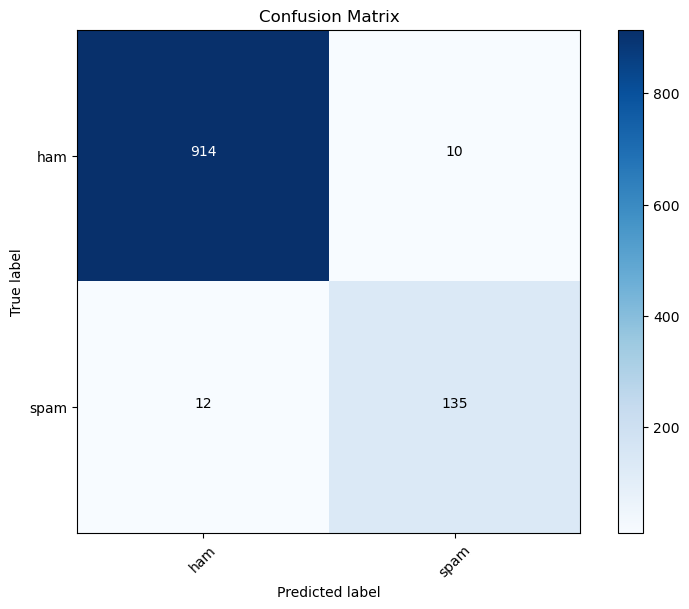

In [21]:
# Convert the PySpark DataFrame to a Pandas DataFrame for confusion matrix
predictions_pd = predictions.select("label_index", "prediction").toPandas()

# Compute the confusion matrix
confusion = confusion_matrix(predictions_pd["label_index"], predictions_pd["prediction"])

# Visualize the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

class_names = ["ham", "spam"]
plot_confusion_matrix(confusion, classes=class_names, title="Confusion Matrix")

plt.show()


In [22]:
# Stop the Spark session
spark.stop()
